In [2]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

#from contextlib import redirect_stdout

# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [64] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'

In [3]:
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)

In [4]:

# class ReturnBestEarlyStopping(EarlyStopping):
#     def __init__(self, **kwargs):
#         super(ReturnBestEarlyStopping, self).__init__(**kwargs)

#     def on_train_end(self, logs=None):
#         if self.stopped_epoch > 0:
#             if self.verbose > 0:
#                 print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
#         elif self.restore_best_weights:
#             if self.verbose > 0:
#                 print('Restoring model weights from the end of the best epoch.')
#             self.model.set_weights(self.best_weights
                                   
# https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb
# Metrics2 modified from https://stackoverflow.com/a/61856587/3023033
class Metrics(Callback):
    def __init__(self, val_data):#, batch_size = 64):
        super().__init__()
        self.validation_data = val_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal = self.validation_data
        val_pred = np.argmax(np.asarray(self.model.predict(xVal)), axis=1)
        val_true = np.argmax(yVal, axis=1)        
        _val_f1 = f1_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_precision = precision_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_recall = recall_score(val_true, val_pred, average='weighted', zero_division = 0)

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        logs["val_f1"] = _val_f1
        logs["val_recall"] = _val_recall
        logs["val_precision"] = _val_precision
        print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return

In [55]:
## TEST
# imd = np.load('../../data/tidy/preprocessed_images/size64_exp5_Pr_Po_Im.npy',allow_pickle = True)
# trimg,vaimg,trlab,valab =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in imd]), 
#                  np.array([x[1] for x in imd]), stratify= np.array([x[1] for x in imd]), test_size=.2, random_state = 1  )
# print(trlab.sum(axis=0))
# print(valab.sum(axis=0))

In [36]:
def trainModelWithDetailedMetrics(image_size, scenario, num_epochs = 10, trial_seed = 1): 
    
    # IMAGES (former approach)
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
#     training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[image_size][scenario]]), 
#                                                                                                np.array([x[1] for x in image_sets[image_size][scenario]]), 
#                                                                                                stratify= np.array([x[1] for x in image_sets[image_size][scenario]]), 
#                                                                                                test_size = .2, random_state = 1)

    print("Number of class training images:", training_labels.sum(axis=0), "total: ", training_labels.sum())
    print("Number of class validation images:", validation_labels.sum(axis=0), "total: ", validation_labels.sum())
    
    # CALLBACKS
    model_metrics = Metrics(val_data=(validation_images, validation_labels))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    # INIT MODEL AND PARAMS, FIT
    K.clear_session()
    ## shape of images
    input_shape = (image_size, image_size, NUM_CHANNELS)
    ## learning rate
    opt_learning_rate = getOptCNNHyperparams(image_size, scenario)['learning_rate']
    opt = tf.keras.optimizers.Adam(learning_rate = opt_learning_rate)
    ## get model
    model = constructBaseCNN(image_size, scenario, num_channels = NUM_CHANNELS)
    reset_weights(model) # re-initialize model weights
    ## compile and fit
    model.compile(loss='categorical_crossentropy',  optimizer = opt, metrics =  ['accuracy']) 
    hist = model.fit(training_images, training_labels, batch_size = 32, epochs = num_epochs, verbose=1, 
                     validation_data=(validation_images, validation_labels),
                     callbacks = [model_metrics, early_stopping])     
    
    # SAVE MODEL, SUMMARY AND PERFORMANCE
    model_name = "opt-cnn-" + scenario + "-" +str(image_size) + "-px"
    model_folder = "model"
    if not os.path.exists(SAVED_MODEL_DIR):  
        os.makedirs(SAVED_MODEL_DIR)
#     model.save(os.path.join(SAVED_MODEL_DIR, model_name, model_folder))
#     ## Save model summary
#     print(os.path.join(SAVED_MODEL_DIR, model_name, "summary.txt"))
#     with open(os.path.join(SAVED_MODEL_DIR, model_name, "summary.txt"), 'w') as f:
#         model.summary(print_fn=lambda x: f.write(x + '\n'))
#     with open(os.path.join(SAVED_MODEL_DIR, model_name, "history.txt"), 'w') as f:
#         f.write(json.dumps(hist.history))    
   
    # ANALYZE PERFORMANCE AND SAVE OUTPUTS
#     if not os.path.exists(MODEL_PERFORMANCE_DIR):  
#         os.makedirs(MODEL_PERFORMANCE_DIR)
    ## Params
    y_pred = np.argmax(model.predict(validation_images), axis=-1) 
    ## Classification report
    report = classification_report(np.argmax(validation_labels, axis=-1), y_pred, zero_division=0,
                                   labels = np.arange(len(class_labels)), target_names=class_labels, output_dict=True)
    print("Classification report for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    report = pd.DataFrame(report).transpose().round(2)
    if not os.path.exists('../../results/classification-reports/'):  
        os.makedirs('../../results/classification-reports/')
    #report_filename = "classification-report" #os.path.join(MODEL_PERFORMANCE_DIR, )
    #report.to_csv("../../results/classification-reports/opt-classification-report-" + scenario + "-" + str(image_size) + "-px.csv")
    print(report)
    
    ## Confusion matrix
    con_mat = tf.math.confusion_matrix(labels=np.argmax(validation_labels, axis=-1), predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index = class_labels, columns = class_labels)
    #print("Confusion matrix for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    #print(con_mat_df)
    ## Confusion matrix heatmap
    figure = plt.figure(figsize=(4, 4))
    ax = sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, fmt='g', cbar = False, annot_kws={"size": 16})
    figure.tight_layout()
    plt.ylabel('True',fontsize=16)
    ax.set_yticklabels(class_labels,va='center',fontsize=14)
    ax.set_xticklabels(class_labels, ha='center',fontsize=14)
    plt.xlabel('Predicted',fontsize=16)
    plt.show()
    con_mat_heatmap_file = "../../figures/test-opt-confusion-matrix-" + scenario + "-" + str(image_size) + "-px.png"
    figure.savefig(con_mat_heatmap_file, dpi=180, bbox_inches='tight')
    return(model, hist) #performance_dict)



Class labels: ['Probable', 'Improbable']
Number of class training images: [  22 1678] total:  1700
Number of class validation images: [  5 420] total:  425
Epoch 1/2
54/54 [==============================] - 12s 196ms/step - loss: 0.2424 - accuracy: 0.9944 - val_loss: 0.5123 - val_accuracy: 0.8235
— val_f1: 0.892734 — val_precision: 0.988971 — val_recall 0.823529
Epoch 2/2
54/54 [==============================] - 10s 191ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.3407 - val_accuracy: 0.8235
— val_f1: 0.892734 — val_precision: 0.988971 — val_recall 0.823529
Classification report for scenario Pr_Im, resolution: 64:
              precision  recall  f1-score  support
Probable           0.06    1.00      0.12     5.00
Improbable         1.00    0.82      0.90   420.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.53    0.91      0.51   425.00
weighted avg       0.99    0.82      0.89   425.00


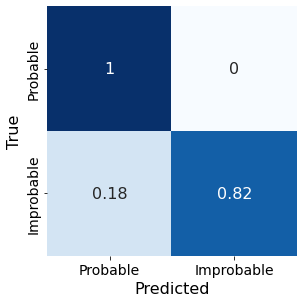

In [37]:
#m, h = trainModelWithDetailedMetrics(64, "Pr_Im", num_epochs = 15)
m,h = trainModelWithDetailedMetrics(64, "Pr_Im", num_epochs = 2)

In [8]:
def visualizeCNN(model, scenario, image_size, images_per_class = 4, seed_num = 1, saliency=False):
    #ALT: use train_test_split
#    trimg,vaimg,trlab,valab =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[64]["Pr_Im"]]), 
#                 np.array([x[1] for x in image_sets[64]["Pr_Im"]]), stratify= np.array([x[1] for x in image_sets[64]["Pr_Im"]]), test_size=.2, random_state = 1  )

    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = 1)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0))
    print(validation_labels.sum(axis=0))    
    
    # GRAD CAM
    random.seed(seed_num)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(seed_num+1)
    random_image_selection_class_1 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(seed_num+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct
    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])
    
    # Loss function for gradcam
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        #loss_tuple = (output[random_image_selection_class_0][0], output[random_image_selection_class_1][1])
        #first image loss (class 1); second image loss (class 2)
        #class_0_losses = [output[i][0] for i in np.arange(images_per_class)] 
        #class_1_losses = [output[i + images_per_class][1] for i in np.arange(images_per_class)]    
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        #print(loss_list)
        #(output[0][0], output[1][1]) #, output[2][2])                        
        #if scenario=="Pr_Po_Im":
            #loss_tuple = (output[random_image_selection_class_0][0], output[random_image_selection_class_1][1], output[random_image_selection_class_2][2])
            #loss_list = (output[0][0], output[1][1], output[2][2])           
        #    class_2_losses = [output[i + 2*images_per_class][2] for i in np.arange(images_per_class)]
        #    loss_list.extend(class_2_losses)
        return loss_list
    
    # Model_modifier function required for gradcam
    def model_modifier(m):
        """Remove softmax activation of last layer in model"""
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier = model_modifier)#, clone=False)

    # Generate heatmap with GradCAM
    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    
    cam = gradcam(loss, gradcam_images, penultimate_layer = -1)
    cam = normalize(cam)
    print(len(cam))
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            heatmap = np.uint8(cm.jet(cam[image_counter])[..., :3] * 255)            
            ax[i, j].imshow(gradcam_images[image_counter])
            ax[i, j].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    plt.show()
    f.savefig("../../figures/opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    
    if saliency==True:
        saliency = Saliency(model, model_modifier=model_modifier)#                    clone=False)

        # Generate saliency map with smoothing that reduce noise by adding noise
        saliency_map = saliency(loss, gradcam_images, 
                                smooth_samples=20, # The number of calculating gradients iterations.
                                smooth_noise=0.20) # noise spread level.
        saliency_map = normalize(saliency_map)
        #image_titles = class_labels
        f, ax = plt.subplots(**subplot_args)
        f.set_facecolor("white")
        image_counter = 0
        for i, label in enumerate(class_labels):
            ax[i,0].set_ylabel(label, fontsize=14)
            for j in np.arange(images_per_class):
                print(i, j, image_counter)
                ax[i, j].imshow(saliency_map[image_counter], cmap='jet', alpha=0.5) # overlay
                image_counter += 1
        plt.tight_layout()
        plt.show()
        f.savefig("../../figures/opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return

In [6]:
def getScenarioModelPerformance(res = 64, num_epochs = 15):
    df = pd.DataFrame()
    for s in SCENARIO_LIST:
        m, h = trainModelWithDetailedMetrics(res, s, num_epochs)
        visualizeCNN(m, s, res, images_per_class = 4, seed_num = 1)       
        perf = pd.DataFrame.from_dict(h.history)
        perf[['Scenario']] = s
        perf['epoch'] = perf.index + 1
        df = df.append(perf, ignore_index=True)
    df_filename = "../../results/opt-cnn-performance-metrics-summary-" + str(res) + "px.csv"
    df.to_csv(df_filename)
    return df

In [13]:
dfm

,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0.542666,0.735294,0.615232,0.757647,0.653179,0.757647,0.574029,Pr_Im,1
1,0.485928,0.771765,0.585822,0.757647,0.653179,0.757647,0.574029,Pr_Im,2
2,0.637079,0.625743,0.662973,0.637624,0.496529,0.637624,0.406564,PrPo_Im,1
3,0.597739,0.673762,0.659182,0.663366,0.566131,0.663366,0.702949,PrPo_Im,2
4,0.619283,0.672772,0.545321,0.796040,0.705640,0.796040,0.633679,Pr_PoIm,1
5,0.486247,0.800000,0.498400,0.796040,0.705640,0.796040,0.633679,Pr_PoIm,2
6,1.016905,0.511386,0.970385,0.637624,0.496529,0.637624,0.406564,Pr_Po_Im,1
7,0.876719,0.638119,0.898135,0.637624,0.496529,0.637624,0.406564,Pr_Po_Im,2


Class labels: ['Probable', 'Improbable']
Number of class training images: [ 412 1288] total:  1700
Number of class validation images: [103 322] total:  425
Epoch 1/2
54/54 [==============================] - 13s 211ms/step - loss: 0.5833 - accuracy: 0.7041 - val_loss: 0.6152 - val_accuracy: 0.7576
— val_f1: 0.653179 — val_precision: 0.574029 — val_recall 0.757647
Epoch 2/2
54/54 [==============================] - 10s 180ms/step - loss: 0.4852 - accuracy: 0.7727 - val_loss: 0.5858 - val_accuracy: 0.7576
— val_f1: 0.653179 — val_precision: 0.574029 — val_recall 0.757647
INFO:tensorflow:Assets written to: ../../results/models/opt-cnn-Pr_Im-64-px/model/assets
../../results/models/opt-cnn-Pr_Im-64-px/summary.txt
Classification report for scenario Pr_Im, resolution: 64:
              precision  recall  f1-score  support
Probable           0.00    0.00      0.00   103.00
Improbable         0.76    1.00      0.86   322.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.3

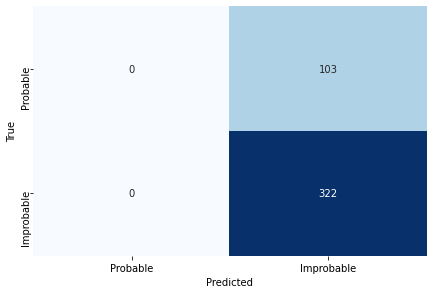

Class labels: ['Probable', 'Improbable']
[ 453 1247]
[102 323]
List of indices from validation images: [100, 317, 417, 61, 33, 53, 50, 243]
Shape of gradcam image array: (8, 64, 64, 1)
[0, 0, 0, 0, 1, 1, 1, 1]
8
0 0 0
0 1 1
0 2 2
0 3 3
1 0 4
1 1 5
1 2 6
1 3 7


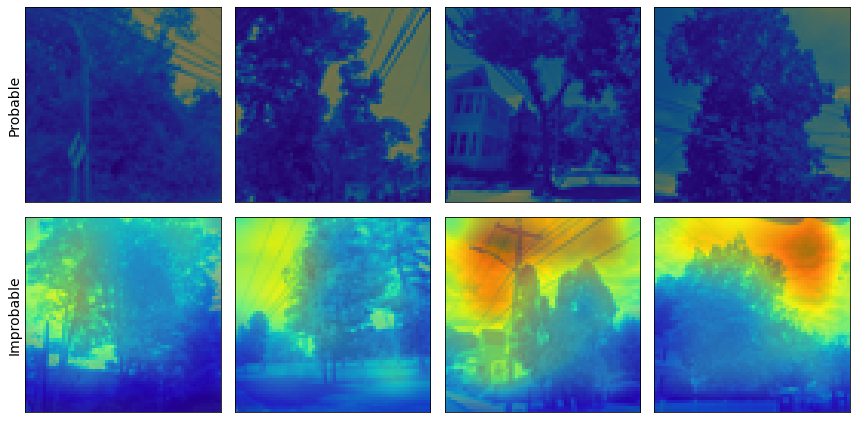

Class labels: ['Probable/Possible', 'Improbable']
Number of class training images: [ 732 1288] total:  2020
Number of class validation images: [183 322] total:  505
Epoch 1/2
64/64 [==============================] - 13s 183ms/step - loss: 0.6479 - accuracy: 0.6195 - val_loss: 0.6630 - val_accuracy: 0.6376
— val_f1: 0.496529 — val_precision: 0.406564 — val_recall 0.637624
Epoch 2/2
64/64 [==============================] - 13s 202ms/step - loss: 0.6142 - accuracy: 0.6668 - val_loss: 0.6592 - val_accuracy: 0.6634
— val_f1: 0.566131 — val_precision: 0.702949 — val_recall 0.663366
INFO:tensorflow:Assets written to: ../../results/models/opt-cnn-PrPo_Im-64-px/model/assets
../../results/models/opt-cnn-PrPo_Im-64-px/summary.txt
Classification report for scenario PrPo_Im, resolution: 64:
                   precision  recall  f1-score  support
Probable/Possible       0.78    0.10      0.17   183.00
Improbable              0.66    0.98      0.79   322.00
accuracy                0.66    0.66      0

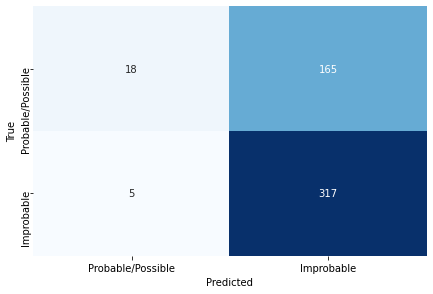

Class labels: ['Probable/Possible', 'Improbable']
[ 777 1243]
[201 304]
List of indices from validation images: [103, 376, 496, 61, 40, 63, 59, 304]
Shape of gradcam image array: (8, 64, 64, 1)
[0, 0, 0, 0, 1, 1, 1, 1]
8
0 0 0
0 1 1
0 2 2
0 3 3
1 0 4
1 1 5
1 2 6
1 3 7


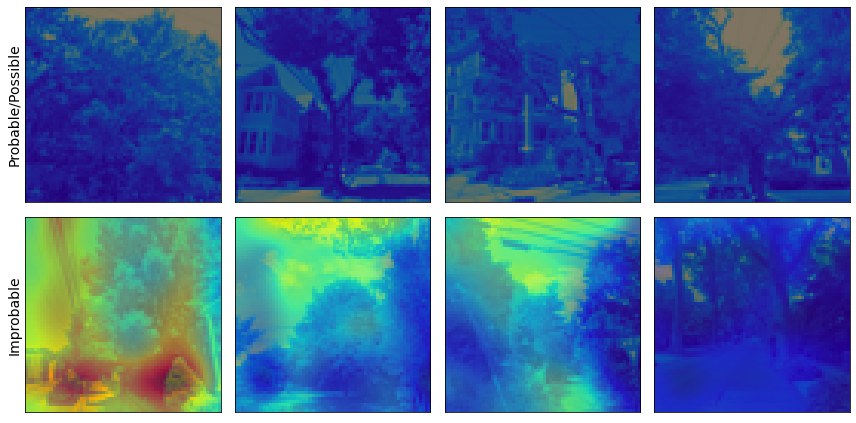

Class labels: ['Probable', 'Possible/Improbable']
Number of class training images: [ 412 1608] total:  2020
Number of class validation images: [103 402] total:  505
Epoch 1/2
64/64 [==============================] - 13s 179ms/step - loss: 0.6619 - accuracy: 0.5955 - val_loss: 0.5453 - val_accuracy: 0.7960
— val_f1: 0.705640 — val_precision: 0.633679 — val_recall 0.796040
Epoch 2/2
64/64 [==============================] - 12s 183ms/step - loss: 0.5111 - accuracy: 0.7878 - val_loss: 0.4984 - val_accuracy: 0.7960
— val_f1: 0.705640 — val_precision: 0.633679 — val_recall 0.796040
INFO:tensorflow:Assets written to: ../../results/models/opt-cnn-Pr_PoIm-64-px/model/assets
../../results/models/opt-cnn-Pr_PoIm-64-px/summary.txt
Classification report for scenario Pr_PoIm, resolution: 64:
                     precision  recall  f1-score  support
Probable                  0.00     0.0      0.00    103.0
Possible/Improbable       0.80     1.0      0.89    402.0
accuracy                  0.80     0.

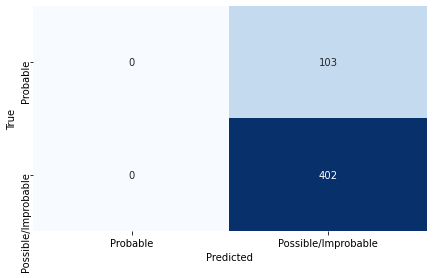

Class labels: ['Probable', 'Possible/Improbable']
[ 401 1619]
[119 386]
List of indices from validation images: [96, 312, 468, 455, 31, 52, 49, 236]
Shape of gradcam image array: (8, 64, 64, 1)
[0, 0, 0, 0, 1, 1, 1, 1]
8
0 0 0
0 1 1
0 2 2
0 3 3
1 0 4
1 1 5
1 2 6
1 3 7


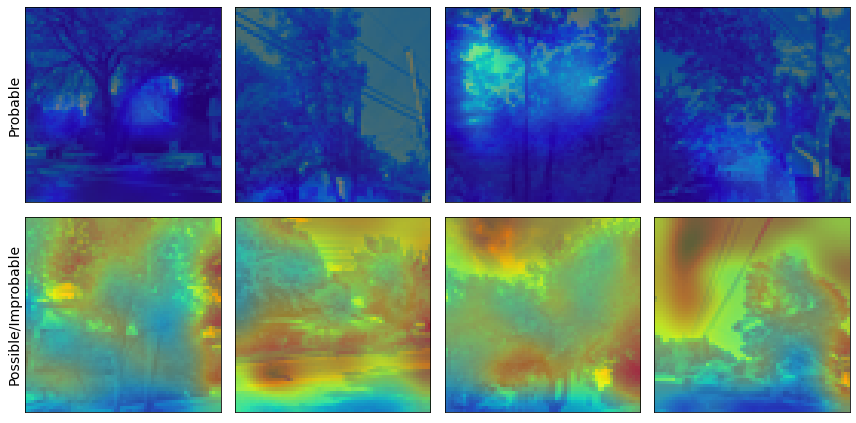

Class labels: ['Probable', 'Possible', 'Improbable']
Number of class training images: [ 412  320 1288] total:  2020
Number of class validation images: [103  80 322] total:  505
Epoch 1/2
64/64 [==============================] - 15s 223ms/step - loss: 1.0484 - accuracy: 0.4600 - val_loss: 0.9704 - val_accuracy: 0.6376
— val_f1: 0.496529 — val_precision: 0.406564 — val_recall 0.637624
Epoch 2/2
64/64 [==============================] - 9s 146ms/step - loss: 0.8975 - accuracy: 0.6257 - val_loss: 0.8981 - val_accuracy: 0.6376
— val_f1: 0.496529 — val_precision: 0.406564 — val_recall 0.637624
INFO:tensorflow:Assets written to: ../../results/models/opt-cnn-Pr_Po_Im-64-px/model/assets
../../results/models/opt-cnn-Pr_Po_Im-64-px/summary.txt
Classification report for scenario Pr_Po_Im, resolution: 64:
              precision  recall  f1-score  support
Probable           0.00    0.00      0.00   103.00
Possible           0.00    0.00      0.00    80.00
Improbable         0.64    1.00      0.78   

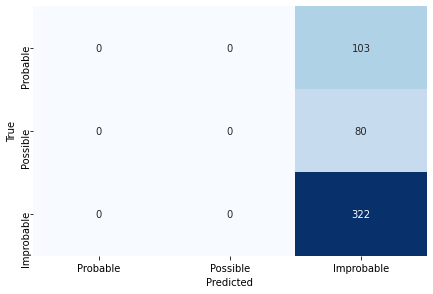

Class labels: ['Probable', 'Possible', 'Improbable']
[ 401  376 1243]
[119  82 304]
List of indices from validation images: [96, 312, 468, 455, 41, 85, 84, 274, 186, 503, 451, 98]
Shape of gradcam image array: (12, 64, 64, 1)
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
12
0 0 0
0 1 1
0 2 2
0 3 3
1 0 4
1 1 5
1 2 6
1 3 7
2 0 8
2 1 9
2 2 10
2 3 11


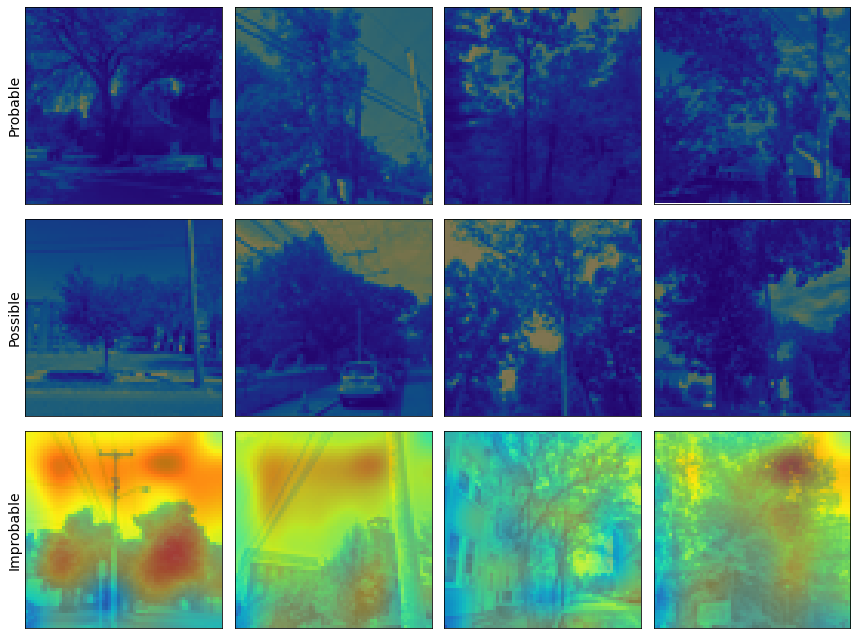

In [9]:
dfm = getScenarioModelPerformance(res = 64, num_epochs = 2)